In [10]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import os, glob
import tensorflow as tf
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.models import Model, Sequential, load_model
from keras.layers import Dense, concatenate, Dropout, Flatten, AvgPool2D,  Conv2D, MaxPool2D, BatchNormalization, GlobalAveragePooling2D,Activation,Input
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras import regularizers
from matplotlib import pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns 
import pandas as pd
import shutil
import numpy as np
from sklearn.metrics import precision_recall_fscore_support
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input
import keras
from matplotlib import pyplot as plt

In [11]:
img_height, img_width = 224, 224
batch_size = 64
train_data_dir = "Dataset2/"
test_data_dir = "Test/"

# Create test directory and move 10% of the data to this directory
if not os.path.exists(test_data_dir):
    os.makedirs(test_data_dir)
    for class_name in os.listdir(train_data_dir):
        class_dir = os.path.join(train_data_dir, class_name)
        test_class_dir = os.path.join(test_data_dir, class_name)
        os.makedirs(test_class_dir)
        files = os.listdir(class_dir)
        n_test = int(len(files) * 0.1)
        test_files = files[:n_test]
        for test_file in test_files:
            src = os.path.join(class_dir, test_file)
            dst = os.path.join(test_class_dir, test_file)
            shutil.move(src, dst)

# Create data generators

train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   validation_split=0.3
                                   )
train_generator = train_datagen.flow_from_directory(train_data_dir,
                                                target_size=(img_height,img_width),
                                                batch_size=batch_size,
                                                class_mode='categorical',
                                                subset='training')
valid_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation')
test_datagen = ImageDataGenerator(rescale=1./255,shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,)
test_generator = test_datagen.flow_from_directory(test_data_dir,
                                                target_size=(img_height,img_width),
                                                batch_size=batch_size,
                                                class_mode='categorical',
                                                
                                                ) 

Found 13333 images belonging to 4 classes.
Found 5711 images belonging to 4 classes.
Found 2114 images belonging to 4 classes.


In [12]:
base_model =tf.keras.applications.NASNetMobile(input_shape=(img_height,img_width, 3), include_top=False,
                          weights='imagenet')
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(4, activation='sigmoid'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
NASNet (Functional)          (None, 7, 7, 1056)        4269716   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1056)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                67648     
_________________________________________________________________
batch_normalization_2 (Batch (None, 64)                256       
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 260       
Total params: 4,337,880
Trainable params: 4,301,014
Non-trainable params: 36,866
_______________________________________

In [13]:
patience = 1
stop_patience = 5
factor = 0.5

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=stop_patience, monitor='val_loss', verbose=1, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=factor, patience=patience, verbose=1) ]

In [14]:
model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=['accuracy'])
history=model.fit(train_generator,epochs=5,verbose=1,validation_data=valid_generator)
model.save("demo1/nasnet.h5")

Epoch 1/5
209/209 [==============================] - 2562s 12s/step - loss: 0.4268 - accuracy: 0.8579 - val_loss: 1.3241 - val_accuracy: 0.5307
Epoch 2/5
209/209 [==============================] - 2404s 12s/step - loss: 0.2343 - accuracy: 0.9159 - val_loss: 0.9766 - val_accuracy: 0.6115
Epoch 3/5
209/209 [==============================] - 2605s 12s/step - loss: 0.2047 - accuracy: 0.9277 - val_loss: 1.8122 - val_accuracy: 0.5276
Epoch 4/5
209/209 [==============================] - 4769s 23s/step - loss: 0.1762 - accuracy: 0.9375 - val_loss: 5.6212 - val_accuracy: 0.4828
Epoch 5/5
209/209 [==============================] - 2684s 13s/step - loss: 0.1703 - accuracy: 0.9388 - val_loss: 5.6015 - val_accuracy: 0.4870


C:\Users\HP\AppData\Roaming\Python\Python36\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [21]:
modelAccuracy = model.evaluate(test_generator, verbose=0)
print('Test Accuracy is {}%'.format(modelAccuracy[1] * 100))

Test Accuracy is 48.53358566761017%


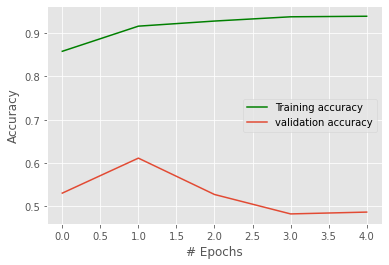

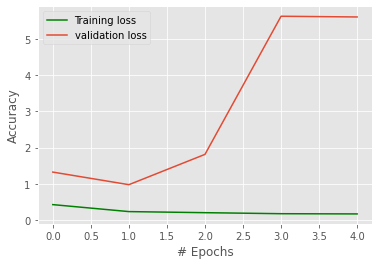

In [16]:
plt.style.use("ggplot")
plt.figure()
plt.plot(history.history['accuracy'],'r',label='Training accuracy',color='green')
plt.plot(history.history['val_accuracy'],label='validation accuracy')
plt.xlabel('# Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig("demo1/Nasnet_acc.png")
plt.show()


plt.style.use("ggplot")
plt.figure()
plt.plot(history.history['loss'],'r',label='Training loss',color='green')
plt.plot(history.history['val_loss'],label='validation loss')
plt.xlabel('# Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig("demo1/Nasnet_loss.png")
plt.show()

In [17]:
class_names = ['COVID-19','Normal','Viral Pneumonia', 'Lung_Opacity']
y_pred = model.predict(test_generator)
print(class_names[np.argmax(y_pred[2])])

Viral Pneumonia


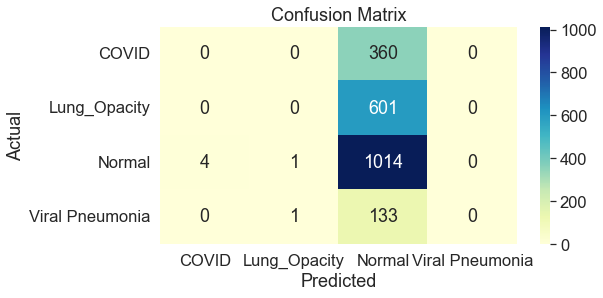

In [18]:
y_pred = model.predict(test_generator) # predict on test_generator

y_pred_classes = np.argmax(y_pred, axis=1) # obtain predicted class labels

conf_mat = confusion_matrix(test_generator.classes, y_pred_classes)

class_names = list(test_generator.class_indices.keys())

conf_mat_df = pd.DataFrame(conf_mat, index=class_names, columns=class_names)

plt.figure(figsize=(8,4))
sns.set(font_scale=1.5, color_codes=True, palette='deep')
sns.heatmap(conf_mat_df, annot=True, fmt='d', cmap="YlGnBu")
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [19]:
y_pred = model.predict(test_generator)
y_pred = np.argmax(y_pred, axis=1)

# Get the true labels
y_true = test_generator.classes

# Calculate precision, recall, and F1-score
precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
print(f'Precision: {precision:.3f}')
print(f'Recall: {recall:.3f}')
print(f'F1-score: {f1_score:.3f}')

Precision: 0.232
Recall: 0.479
F1-score: 0.312


C:\Users\HP\AppData\Roaming\Python\Python36\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [22]:
from sklearn.metrics import classification_report

# Generate predictions for all test data
y_pred = model.predict_generator(test_generator)

# Extract predicted labels batch by batch
y_pred_classes = []
for i in range(len(test_generator)):
    x_batch, y_batch = next(test_generator)
    y_pred_batch = model.predict(x_batch)
    y_pred_batch_classes = np.argmax(y_pred_batch, axis=1)
    y_pred_classes.extend(y_pred_batch_classes)

# Concatenate predicted labels for all test data
y_true = test_generator.classes
y_pred_classes = np.array(y_pred_classes)

# Print classification report
target_names = test_generator.class_indices.keys()
print(classification_report(y_true, y_pred_classes, target_names=target_names))


C:\Users\HP\AppData\Roaming\Python\Python36\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


                 precision    recall  f1-score   support

          COVID       0.08      0.00      0.01       360
   Lung_Opacity       1.00      0.00      0.01       601
         Normal       0.48      0.99      0.65      1019
Viral Pneumonia       0.00      0.00      0.00       134

       accuracy                           0.48      2114
      macro avg       0.39      0.25      0.17      2114
   weighted avg       0.53      0.48      0.32      2114



C:\Users\HP\AppData\Roaming\Python\Python36\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\HP\AppData\Roaming\Python\Python36\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\HP\AppData\Roaming\Python\Python36\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
